<a href="https://colab.research.google.com/github/lolobq/ECGR-5106-Intro_To_Deep_Learning/blob/main/Homework1/DeepLearningHomework1Problem2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and Data


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, StandardScaler
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set the device if the gpu is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get the data
df =  pd.read_csv('https://raw.githubusercontent.com/lolobq/ECGR-5106-Intro_To_Deep_Learning/master/Homework1/house-train.csv')
selected_cols = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF'
                , 'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces'
                ,'LotFrontage','WoodDeckSF','OpenPorchSF'
                ,'ExterQual','Neighborhood','MSZoning'
                ,'Alley','LotShape','LandContour','Condition1','HouseStyle','MasVnrType','SaleCondition', 'SalePrice']
df1 =  df[selected_cols].copy()

# Problem 2a

Please implement the following steps for the housing dataset we overviewed during the lectures. Build a multi-perceptron network that regresses the housing price (based on 20%, 80% split). Use the same number of features we did in the lecture without on-hot encoding. Please plot the training and validation results and report final accuracy and model complexity

Total Training Time: 0.07 seconds
Epoch 1/75, Training Loss: 38848385753.42466 , Validation Loss:  39421469289.20548 , Validation RMSE:   198548.40540584928
Total Training Time: 0.15 seconds
Epoch 2/75, Training Loss: 36751628147.72603 , Validation Loss:  32399920590.90411 , Validation RMSE:   179999.77941904293
Total Training Time: 0.23 seconds
Epoch 3/75, Training Loss: 18939180017.972603 , Validation Loss:  6469473076.602739 , Validation RMSE:   80433.03473450906
Total Training Time: 0.31 seconds
Epoch 4/75, Training Loss: 6581576563.7260275 , Validation Loss:  4879733376.0 , Validation RMSE:   69855.08840449635
Total Training Time: 0.39 seconds
Epoch 5/75, Training Loss: 5398816918.79452 , Validation Loss:  4255891100.0547943 , Validation RMSE:   65237.19108035534
Total Training Time: 0.48 seconds
Epoch 6/75, Training Loss: 4554230279.013699 , Validation Loss:  3448799736.9863014 , Validation RMSE:   58726.48241625154
Total Training Time: 0.57 seconds
Epoch 7/75, Training Loss: 386

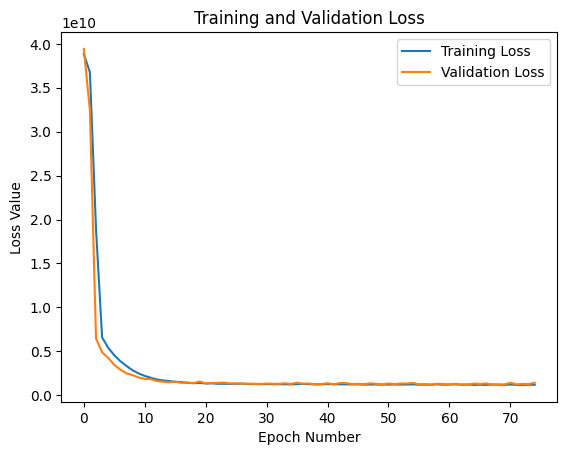

In [16]:
features = df1.drop(['SalePrice'], axis=1)
targets = df1['SalePrice'].values.reshape(-1, 1)

# Convert all values to numbers and declare them as 0s if any values are NaNs
features = features.apply(pd.to_numeric, errors='coerce').fillna(0)
features = StandardScaler().fit_transform(features)

# Split the data into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(features, targets, test_size=0.2, random_state=42)
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
x_val = torch.tensor(x_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

# Create TensorDatasets and DataLoaders for train and validation sets
train_dataset = TensorDataset(x_train, y_train)
valid_dataset = TensorDataset(x_val, y_val)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False)

# Model definition
class RegressionNet(nn.Module):
    def __init__(self, input):
        super(RegressionNet, self).__init__()
        self.fc1 = nn.Linear(input, 248)  # 21 inputs
        self.fc2 = nn.Linear(248, 64)
        self.fc3 = nn.Linear(64, 8)
        self.fc4 = nn.Linear(8, 1)  # 1 output

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Instantiate the model
model = RegressionNet(input=x_train.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 75
training_losses = []
validation_losses = []
total_start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    start_time = time.time()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Calculate training loss
        running_loss += loss.item() * inputs.size(0)

    # Calculate training time
    end_time = time.time()
    training_time = end_time - start_time

    running_loss /= len(train_loader.dataset)
    training_losses.append(running_loss)

    # Print total training time
    total_end_time = time.time()
    total_training_time = total_end_time - total_start_time
    print(f'Total Training Time: {total_training_time:.2f} seconds')

    # Testing the model
    model.eval()
    val_loss = 0.0
    val_total = 0.0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_total += ((outputs - labels) ** 2).sum().item()

    # Update validation loss
    val_loss /= len(validation_loader.dataset)
    validation_losses.append(val_loss)
    rmse = np.sqrt(val_total / len(validation_loader.dataset))

    # Print training statistics
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss} , Validation Loss:  {val_loss} , Validation RMSE:   {rmse}')


print(f'Final Training Loss: {training_losses[-1]}')
print(f'Final Validation Loss: {validation_losses[-1]}')
print(f'Final Validation RMSE: {rmse}')
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss Value')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Problem 2b

Build a multi-perceptron network that regresses the housing price (based on 20%, 80% split). Use the same number of features we did in the lecture, but this time also add on-hot encoding. Please plot the training and validation results and report the final accuracy and model complexity. Do you see the meaningful changes against 2.a.

Total Training Time: 0.10 seconds
Epoch 1/75, Training Loss: 38470451648.87671 , Validation Loss:  36995996517.69863 , Validation RMSE:   192343.4337784855
Total Training Time: 0.19 seconds
Epoch 2/75, Training Loss: 21508472789.91781 , Validation Loss:  7447836419.506849 , Validation RMSE:   86300.84831278803
Total Training Time: 0.29 seconds
Epoch 3/75, Training Loss: 4895008354.191781 , Validation Loss:  2601766848.8767123 , Validation RMSE:   51007.517572184515
Total Training Time: 0.40 seconds
Epoch 4/75, Training Loss: 2605057837.589041 , Validation Loss:  2207997861.6986303 , Validation RMSE:   46989.337744839846
Total Training Time: 0.49 seconds
Epoch 5/75, Training Loss: 1954776591.7808218 , Validation Loss:  1873451752.328767 , Validation RMSE:   43283.388872970274
Total Training Time: 0.59 seconds
Epoch 6/75, Training Loss: 1575547756.7123287 , Validation Loss:  1692638488.9863014 , Validation RMSE:   41141.68796958021
Total Training Time: 0.70 seconds
Epoch 7/75, Training L

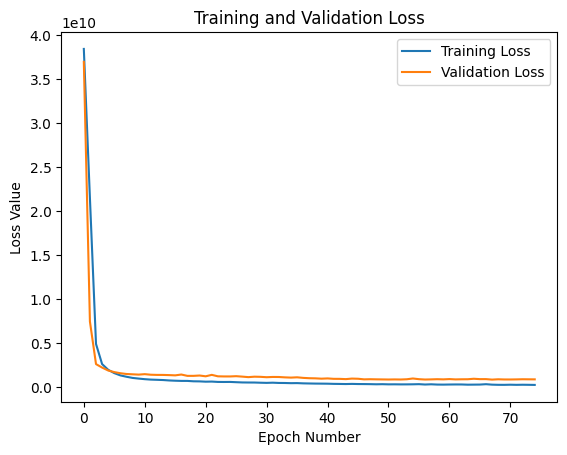

In [17]:
# One hot encoding
encoded_columns = ['Neighborhood','MSZoning','Alley','LotShape','LandContour','Condition1','HouseStyle','MasVnrType','SaleCondition']
df1 = pd.get_dummies(df1, columns=encoded_columns)
df1 = df1.replace({True: 1, False: 0})

# Separate features and targets
features = df1.drop(['SalePrice'], axis=1)
targets = df1['SalePrice'].values.reshape(-1, 1)

# Convert all values to numbers and declare them as 0s if any values are NaNs
features = features.apply(pd.to_numeric, errors='coerce').fillna(0)

# Standardize the features
features = StandardScaler().fit_transform(features)

# Split the data into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(features, targets, test_size=0.2, random_state=42)
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
x_val = torch.tensor(x_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

# Create TensorDatasets and DataLoaders for train and validation sets
train_dataset = TensorDataset(x_train, y_train)
valid_dataset = TensorDataset(x_val, y_val)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False)

# Model definition
class RegressionNet(nn.Module):
    def __init__(self, input):
        super(RegressionNet, self).__init__()
        self.fc1 = nn.Linear(input, 248)  # 21 inputs
        self.fc2 = nn.Linear(248, 64)
        self.fc3 = nn.Linear(64, 8)
        self.fc4 = nn.Linear(8, 1)  # 1 output

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Instantiate the model
model = RegressionNet(input=x_train.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 75
training_losses = []
validation_losses = []
total_start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    start_time = time.time()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Calculate training loss
        running_loss += loss.item() * inputs.size(0)

    # Calculate training time
    end_time = time.time()
    training_time = end_time - start_time

    running_loss /= len(train_loader.dataset)
    training_losses.append(running_loss)

    # Print total training time
    total_end_time = time.time()
    total_training_time = total_end_time - total_start_time
    print(f'Total Training Time: {total_training_time:.2f} seconds')

    # Testing the model
    model.eval()
    val_loss = 0.0
    val_total = 0.0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_total += ((outputs - labels) ** 2).sum().item()

    # Update validation loss
    val_loss /= len(validation_loader.dataset)
    validation_losses.append(val_loss)
    rmse = np.sqrt(val_total / len(validation_loader.dataset))

    # Print training statistics
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss} , Validation Loss:  {val_loss} , Validation RMSE:   {rmse}')


print(f'Final Training Loss: {training_losses[-1]}')
print(f'Final Validation Loss: {validation_losses[-1]}')
print(f'Final Validation RMSE: {rmse}')
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss Value')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Problem 2c

Increase the complexity of the network for problem 2. b and compare your results against 2.b.

Total Training Time: 0.12 seconds
Epoch 1/75, Training Loss: 19585418289.09589 , Validation Loss:  2648770139.178082 , Validation RMSE:   51466.203854355546
Total Training Time: 0.22 seconds
Epoch 2/75, Training Loss: 1823181350.5753424 , Validation Loss:  1464162848.8767123 , Validation RMSE:   38264.380942029005
Total Training Time: 0.32 seconds
Epoch 3/75, Training Loss: 1175574034.410959 , Validation Loss:  1381705101.369863 , Validation RMSE:   37171.29405024613
Total Training Time: 0.42 seconds
Epoch 4/75, Training Loss: 834375651.0684931 , Validation Loss:  1189236169.8630137 , Validation RMSE:   34485.303679437326
Total Training Time: 0.52 seconds
Epoch 5/75, Training Loss: 721680080.2191781 , Validation Loss:  1124444977.7534246 , Validation RMSE:   33532.744858621765
Total Training Time: 0.62 seconds
Epoch 6/75, Training Loss: 614657560.9863014 , Validation Loss:  1203941028.8219178 , Validation RMSE:   34697.85337484032
Total Training Time: 0.73 seconds
Epoch 7/75, Training 

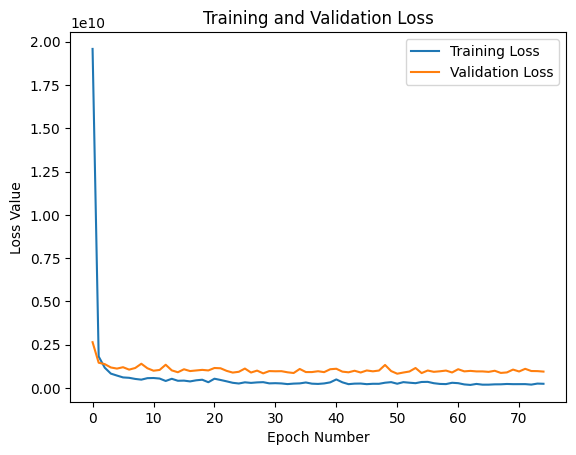

In [19]:
df2 =  df[selected_cols].copy()

# One hot encoding
encoded_columns = ['Neighborhood','MSZoning','Alley','LotShape','LandContour','Condition1','HouseStyle','MasVnrType','SaleCondition']
df2 = pd.get_dummies(df2, columns=encoded_columns)
df2 = df2.replace({True: 1, False: 0})

# Separate features and targets
features = df2.drop(['SalePrice'], axis=1)
targets = df2['SalePrice'].values.reshape(-1, 1)

# Convert all values to numbers and declare them as 0s if any values are NaNs
features = features.apply(pd.to_numeric, errors='coerce').fillna(0)

# Standardize the features
features = StandardScaler().fit_transform(features)

# Split the data into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(features, targets, test_size=0.2, random_state=42)
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
x_val = torch.tensor(x_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

# Create TensorDatasets and DataLoaders for train and validation sets
train_dataset = TensorDataset(x_train, y_train)
valid_dataset = TensorDataset(x_val, y_val)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False)

# Model definition
class RegressionNet(nn.Module):
    def __init__(self, input):
        super(RegressionNet, self).__init__()
        self.fc1 = nn.Linear(input, 512)  # Increase width
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 1)    # 1 output

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        return x

# Instantiate the model
model = RegressionNet(input=x_train.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 75
training_losses = []
validation_losses = []
total_start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    start_time = time.time()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Calculate training loss
        running_loss += loss.item() * inputs.size(0)

    # Calculate training time
    end_time = time.time()
    training_time = end_time - start_time

    running_loss /= len(train_loader.dataset)
    training_losses.append(running_loss)

    # Print total training time
    total_end_time = time.time()
    total_training_time = total_end_time - total_start_time
    print(f'Total Training Time: {total_training_time:.2f} seconds')

    # Testing the model
    model.eval()
    val_loss = 0.0
    val_total = 0.0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_total += ((outputs - labels) ** 2).sum().item()

    # Update validation loss
    val_loss /= len(validation_loader.dataset)
    validation_losses.append(val_loss)
    rmse = np.sqrt(val_total / len(validation_loader.dataset))

    # Print training statistics
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss} , Validation Loss:  {val_loss} , Validation RMSE:   {rmse}')


print(f'Final Training Loss: {training_losses[-1]}')
print(f'Final Validation Loss: {validation_losses[-1]}')
print(f'Final Validation RMSE: {rmse}')
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss Value')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()